<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0"> </div>
    <div style="float: left; margin-left: 10px;"> <h1>LangChain for Generative AI</h1>
<h1>Generative Models</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
</div>

In [1]:
from collections import Counter
from pprint import pprint
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from IPython.display import Image

import requests
import shutil

import openai
from openai import OpenAI

import transformers
from transformers import pipeline
from transformers import set_seed
set_seed(42) # Set the seed to get reproducible results

from tqdm.notebook import tqdm

import watermark

%load_ext watermark
%matplotlib inline

We start by print out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.12.1
IPython version      : 8.21.0

Compiler    : Clang 13.0.0 (clang-1300.0.29.30)
OS          : Darwin
Release     : 23.5.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

Git hash: cc526109102c100be511b85d0872c4bdfd674d94

matplotlib  : 3.8.3
watermark   : 2.4.3
requests    : 2.31.0
transformers: 4.39.0.dev0
openai      : 1.23.2
numpy       : 1.26.4
pandas      : 2.2.1



Load default figure style

In [3]:
plt.style.use('./d4sci.mplstyle')

## OpenAI

In [4]:
client = OpenAI()

The recommended model for exploration is `gpt-3.5-turbo`, so we'll stick with it for now. The basic setup is relatively straightforward:

### Simple interaction

In [5]:
response = client.chat.completions.create(
  model="gpt-3.5-turbo",
  messages=[
        {
            "role": "user", 
            "content": "What was Superman's weakness?"
        },
    ]
)

Which produces the expected response

In [8]:
response.choices[0].message.content

"Superman's weakness is kryptonite, a radioactive substance from his home planet of Krypton. Exposure to kryptonite weakens him and can even kill him if he is exposed to a large amount of it."

### Multiple alternatives

To request multiple answers, we must include the `n` parameter with the number of answers we want

In [9]:
%%time
response = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[
        {"role": "user", "content": "What are the different kinds of Kryptonite?"},
    ],
    n=3
)

CPU times: user 12.8 ms, sys: 3.04 ms, total: 15.8 ms
Wall time: 4.81 s


And we can access each of the answers individually int he choices list

In [10]:
for output in response.choices:
    print("==========")
    print(output.message.role.title()) 
    print("==========")
    print(output.message.content)
    print("==========\n")

Assistant
There are several different kinds of Kryptonite in the DC Comics universe. Some of the most well-known types include:

1. Green Kryptonite - The most common form of Kryptonite, green Kryptonite is deadly to Kryptonians like Superman and weakens them, causing them to lose their powers and become vulnerable to harm.

2. Red Kryptonite - This type of Kryptonite has unpredictable effects on Kryptonians, causing them to undergo temporary and usually negative changes in their powers and personalities.

3. Blue Kryptonite - Blue Kryptonite has the opposite effect of green Kryptonite, boosting the powers of Kryptonians instead of weakening them.

4. Gold Kryptonite - Gold Kryptonite permanently removes a Kryptonian's powers, effectively turning them into a normal human.

5. White Kryptonite - White Kryptonite is deadly to plant life, making it a dangerous weapon against plant-based foes.

6. Black Kryptonite - Black Kryptonite can split a Kryptonian into two separate beings, each wit

### Language Translation

In [11]:
response = client.chat.completions.create(
    model='gpt-3.5-turbo',
    messages=[{"role": "system", "content": "You're a professional English-Italian translator."}, 
              {"role": "user", "content": "Translate 'Be the change that you wish to see in the world.' into Italian"}],
    temperature=0,
)

In [12]:
response.choices[0].message.content

'"Sii il cambiamento che desideri vedere nel mondo."'

### Image generation

In [20]:
prompt = "A wimsical image of a toy duck with an eye patch and hat floating in the clouds, laughing"

In [21]:
%%time
response = client.images.generate(
    model="dall-e-3",
    prompt=prompt,
    n=1,
    size="1024x1024",
    response_format="url",
)

CPU times: user 11.5 ms, sys: 8.28 ms, total: 19.8 ms
Wall time: 17.8 s


Utility function to download the image

In [22]:
def download_file(url, filename):
    with requests.get(url, stream=True) as r:
        total_length = int(r.headers.get("Content-Length"))
        with tqdm.wrapattr(r.raw, "read", total=total_length, desc=filename) as raw:
            with open(filename, 'wb')as output:
                shutil.copyfileobj(raw, output)

In [23]:
image_dir = 'images/'

In [24]:
image_url = response.data[0].url

In [25]:
image_filename = os.path.join(image_dir, 'ducky2.png')
download_file(image_url, image_filename)

images/ducky2.png:   0%|          | 0/3162696 [00:00<?, ?it/s]

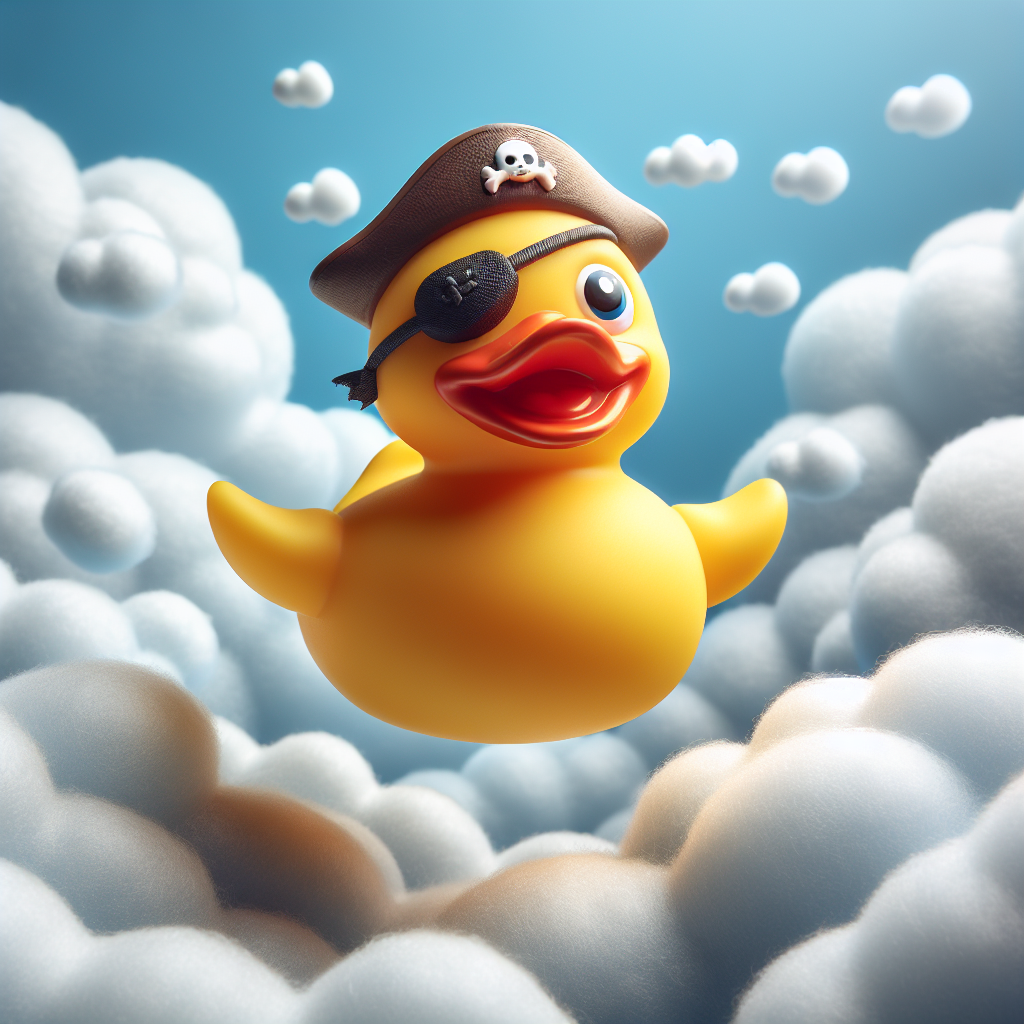

In [26]:
Image(filename=image_filename)

## HuggingFace

In [27]:
unmasker = pipeline('fill-mask', model='bert-base-uncased') # based - has only 6 layers

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [28]:
unmasker("Artificial Intelligence [MASK] take over the world.") # The model will try to guess the placeholder [MASK] 

[{'score': 0.3182421028614044,
  'token': 2064,
  'token_str': 'can',
  'sequence': 'artificial intelligence can take over the world.'},
 {'score': 0.18299749493598938,
  'token': 2097,
  'token_str': 'will',
  'sequence': 'artificial intelligence will take over the world.'},
 {'score': 0.05600126460194588,
  'token': 2000,
  'token_str': 'to',
  'sequence': 'artificial intelligence to take over the world.'},
 {'score': 0.045194774866104126,
  'token': 2015,
  'token_str': '##s',
  'sequence': 'artificial intelligences take over the world.'},
 {'score': 0.04515307769179344,
  'token': 2052,
  'token_str': 'would',
  'sequence': 'artificial intelligence would take over the world.'}]

### Question answering

In [29]:
text = """Dear Amazon, last week I ordered an Optimus Prime action figure \
from your online store in Germany. Unfortunately, when I opened the package, \
I discovered to my horror that I had been sent an action figure of Megatron \
instead! As a lifelong enemy of the Decepticons, I hope you can understand my \
dilemma. To resolve the issue, I demand an exchange of Megatron for the \
Optimus Prime figure I ordered. Enclosed are copies of my records concerning \
this purchase. I expect to hear from you soon. Sincerely, Bumblebee."""

In [30]:
# Since no model was mentioned, it will use the best Model that it thinks will be able to answer this question. 
reader = pipeline("question-answering")
question = "What does the customer want?"
outputs = reader(question=question, context=text)
pd.DataFrame([outputs])    

No model was supplied, defaulted to distilbert/distilbert-base-cased-distilled-squad and revision 626af31 (https://huggingface.co/distilbert/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/261M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

score  start  end                   answer
0  0.631292    335  358  an exchange of Megatron

### Named Entity Recognition

In [31]:
ner_tagger = pipeline("ner", aggregation_strategy="simple")
outputs = ner_tagger(text)
pd.DataFrame(outputs)    

No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/998 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Error while downloading from https://cdn-lfs.huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english/9a90b161380a5549418764749cabe9257dce2df7fa58bcec648289f00f982ebb?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27model.safetensors%3B+filename%3D%22model.safetensors%22%3B&Expires=1717871771&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcxNzg3MTc3MX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9kYm1kei9iZXJ0LWxhcmdlLWNhc2VkLWZpbmV0dW5lZC1jb25sbDAzLWVuZ2xpc2gvOWE5MGIxNjEzODBhNTU0OTQxODc2NDc0OWNhYmU5MjU3ZGNlMmRmN2ZhNThiY2VjNjQ4Mjg5ZjAwZjk4MmViYj9yZXNwb25zZS1jb250ZW50LWRpc3Bvc2l0aW9uPSoifV19&Signature=Uk69smJjzVT-YEZj%7EbCLei3eWkaNC1aNX43aapHmVfWzNT06i7AJQC7UDANz4tIDvw0XMPBUSgXbgSwbKGcYcpw-FxC3jfrkmyKGQwH-49X5B8hSnLciUIb6aFm7msvc%7EtoLNWhppizDTptXqcmEW2l8APOCbH1ffaALHdKjI0a5kHLDMLY8kuO4LczOV4tO%7Etrhd%7E8fdDWG4L2yoEEoQLF6WJpiD5scAvD4Nl3tz4-dg7b9xOdtQ6dGjwNWSp-EOq0EL3HK3bf%7EPKkpTE9JlN908I%7EiSF4B1DUGeQdfBtc9

model.safetensors:  57%|#####6    | 755M/1.33G [00:00<?, ?B/s]

Error while downloading from https://cdn-lfs.huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english/9a90b161380a5549418764749cabe9257dce2df7fa58bcec648289f00f982ebb?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27model.safetensors%3B+filename%3D%22model.safetensors%22%3B&Expires=1717871771&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcxNzg3MTc3MX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9kYm1kei9iZXJ0LWxhcmdlLWNhc2VkLWZpbmV0dW5lZC1jb25sbDAzLWVuZ2xpc2gvOWE5MGIxNjEzODBhNTU0OTQxODc2NDc0OWNhYmU5MjU3ZGNlMmRmN2ZhNThiY2VjNjQ4Mjg5ZjAwZjk4MmViYj9yZXNwb25zZS1jb250ZW50LWRpc3Bvc2l0aW9uPSoifV19&Signature=Uk69smJjzVT-YEZj%7EbCLei3eWkaNC1aNX43aapHmVfWzNT06i7AJQC7UDANz4tIDvw0XMPBUSgXbgSwbKGcYcpw-FxC3jfrkmyKGQwH-49X5B8hSnLciUIb6aFm7msvc%7EtoLNWhppizDTptXqcmEW2l8APOCbH1ffaALHdKjI0a5kHLDMLY8kuO4LczOV4tO%7Etrhd%7E8fdDWG4L2yoEEoQLF6WJpiD5scAvD4Nl3tz4-dg7b9xOdtQ6dGjwNWSp-EOq0EL3HK3bf%7EPKkpTE9JlN908I%7EiSF4B1DUGeQdfBtc9

model.safetensors:  57%|#####7    | 765M/1.33G [00:00<?, ?B/s]

Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

entity_group     score           word  start  end
0          ORG  0.879011         Amazon      5   11
1         MISC  0.990859  Optimus Prime     36   49
2          LOC  0.999755        Germany     90   97
3         MISC  0.556571           Mega    208  212
4          PER  0.590255         ##tron    212  216
5          ORG  0.669692         Decept    253  259
6         MISC  0.498349        ##icons    259  264
7         MISC  0.775362       Megatron    350  358
8         MISC  0.987854  Optimus Prime    367  380
9          PER  0.812096      Bumblebee    502  511

<center>
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</center>